# PCA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # Optional: if you want distinct train/test
import time

print("Loading MNIST dataset using fetch_openml...")
# Load data from https://www.openml.org/d/554
# It's generally faster than the older fetch_mldata
# The data is returned as a Pandas DataFrame by default if available,
# specify return_X_y=True to get numpy arrays directly.
# as_frame=False ensures numpy arrays even if pandas is installed.
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='liac-arff')

# Convert labels to integers
y = y.astype(np.uint8)

# Normalize pixel values to be between 0 and 1 (optional but common)
# Alternatively, StandardScaler handles mean/variance
# X = X / 255.0

# --- Data Subsampling (Optional, speeds up processing/plotting) ---
# Use a smaller subset for faster PCA fitting and visualization
n_samples_to_use = 10000 # Adjust as needed
random_indices = np.random.choice(X.shape[0], n_samples_to_use, replace=False)
X_subset = X[random_indices]
y_subset = y[random_indices]
print(f"Using a subset of {n_samples_to_use} samples.")


# --- Preprocessing: Scaling ---
# PCA is sensitive to feature scaling. Standardize features (mean=0, std=1)
print("Scaling data...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_subset) # Fit and transform the subset

# --- PCA Parameters ---
# Choose a number of components for reconstruction comparison (e.g., same as AE encoding_dim)
encoding_dim_pca = 32
n_components_viz = 2 # For 2D visualization

# --- PCA for Reconstruction ---
print(f"\nApplying PCA for Reconstruction (n_components={encoding_dim_pca})...")
start_time = time.time()
pca_recon = PCA(n_components=encoding_dim_pca)
# Fit PCA on the scaled data
pca_recon.fit(X_scaled)
# Transform data to the lower dimension
X_pca_recon = pca_recon.transform(X_scaled)
# Reconstruct data back to the original (scaled) dimension
X_reconstructed_scaled = pca_recon.inverse_transform(X_pca_recon)
# Inverse scale to get back to original pixel value range
X_reconstructed = scaler.inverse_transform(X_reconstructed_scaled)
end_time = time.time()
print(f"PCA fitting and reconstruction took {end_time - start_time:.2f} seconds.")

print("PCA Reconstruction Results:")
print("Original data shape:", X_scaled.shape)
print("PCA reduced data shape:", X_pca_recon.shape)
print("Reconstructed data shape:", X_reconstructed.shape)

Loading MNIST dataset using fetch_openml...
Using a subset of 10000 samples.
Scaling data...

Applying PCA for Reconstruction (n_components=32)...
PCA fitting and reconstruction took 0.46 seconds.
PCA Reconstruction Results:
Original data shape: (10000, 784)
PCA reduced data shape: (10000, 32)
Reconstructed data shape: (10000, 784)


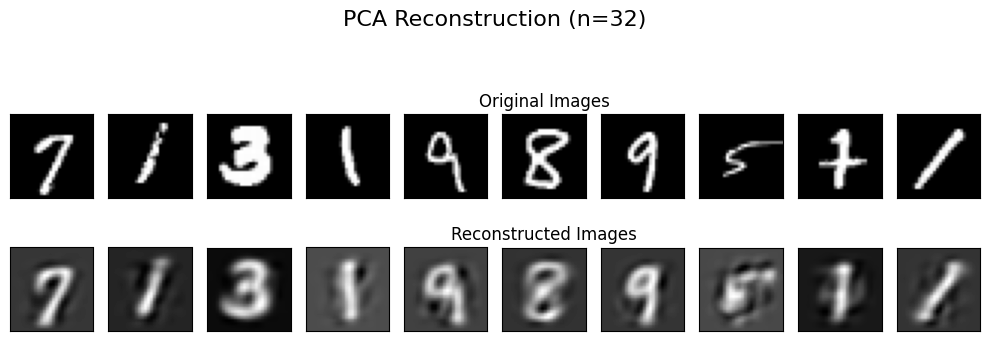


Note: Reconstructed images from PCA are often blurrier than those from AEs/VAEs for the same number of latent dimensions due to PCA's linearity.


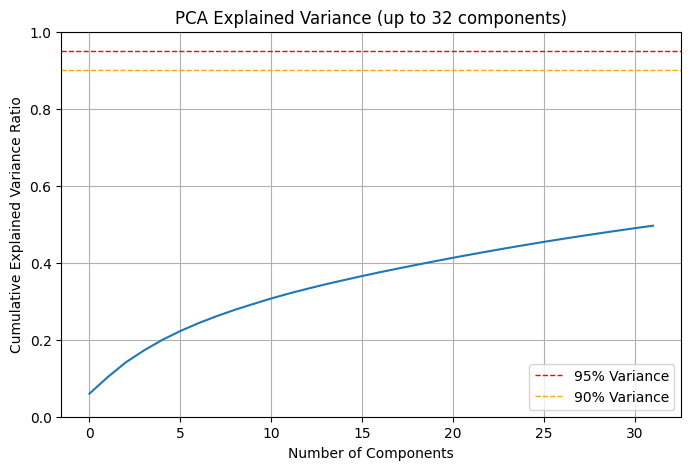

Total variance explained by 32 components: 0.4961


In [2]:
# --- Visualization: Original vs. Reconstructed ---
n_display = 10
plt.figure(figsize=(10, 4))
plt.suptitle(f'PCA Reconstruction (n={encoding_dim_pca})', fontsize=16)
for i in range(n_display):
    # display original (from the subset used)
    ax = plt.subplot(2, n_display, i + 1)
    plt.imshow(X_subset[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n_display // 2:
        ax.set_title("Original Images")

    # display reconstruction
    ax = plt.subplot(2, n_display, i + 1 + n_display)
    plt.imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n_display // 2:
        ax.set_title("Reconstructed Images")
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

print("\nNote: Reconstructed images from PCA are often blurrier than those from AEs/VAEs",
      "for the same number of latent dimensions due to PCA's linearity.")


# --- Explained Variance ---
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca_recon.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title(f'PCA Explained Variance (up to {encoding_dim_pca} components)')
plt.grid(True)
plt.ylim(0, 1.0)
plt.axhline(0.95, color='red', linestyle='--', linewidth=1, label='95% Variance')
plt.axhline(0.90, color='orange', linestyle='--', linewidth=1, label='90% Variance')
plt.legend()
plt.show()

explained_var_total = np.sum(pca_recon.explained_variance_ratio_)
print(f"Total variance explained by {encoding_dim_pca} components: {explained_var_total:.4f}")


Applying PCA for 2D Visualization (n_components=2)...
PCA 2D reduced data shape: (10000, 2)


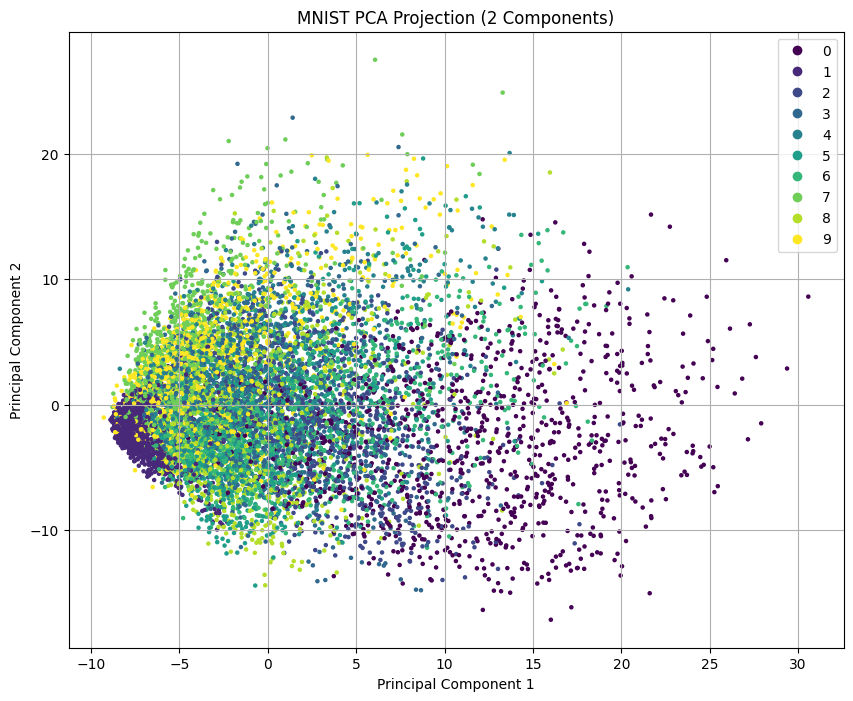


The 2D plot shows how PCA linearly separates the digit classes. Observe the overlap between certain digits.


In [3]:
# --- PCA for 2D Visualization ---
print(f"\nApplying PCA for 2D Visualization (n_components={n_components_viz})...")
pca_viz = PCA(n_components=n_components_viz)
# Fit and transform the scaled data to 2 dimensions
X_pca_viz = pca_viz.fit_transform(X_scaled) # Can refit or use transform if pca_recon had >= 2 components

print("PCA 2D reduced data shape:", X_pca_viz.shape)

# --- Visualization: 2D Latent Space ---
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca_viz[:, 0], X_pca_viz[:, 1], c=y_subset, cmap='viridis', s=5) # Use subset labels
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('MNIST PCA Projection (2 Components)')
plt.legend(handles=scatter.legend_elements()[0], labels=list(np.unique(y_subset).astype(str)))
plt.grid(True)
plt.show()

print("\nThe 2D plot shows how PCA linearly separates the digit classes.",
      "Observe the overlap between certain digits.")

# Autoencoder

In [7]:
!pip install pillow==10.2.0 --force-reinstall


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Parameters
input_dim = 784  # MNIST images are 28x28 = 784 pixels
encoding_dim = 32 # Dimension of the latent space (bottleneck)
hidden_dim = 128 # Dimension of hidden layer
num_epochs = 20
batch_size = 256
learning_rate = 1e-3

# Define the Autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, encoding_dim),
            nn.ReLU(True) # Often ReLU is used here too, or linear
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hidden_dim),
            nn.ReLU(True),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid() # Sigmoid activation for output pixels in [0, 1]
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

    def encode(self, x):
        # Helper function to get latent representation
        return self.encoder(x)

    def decode(self, z):
         # Helper function to decode from latent space
        return self.decoder(z)

  Using cached pillow-10.2.0-cp312-cp312-win_amd64.whl.metadata (9.9 kB)
Using cached pillow-10.2.0-cp312-cp312-win_amd64.whl (2.6 MB)
  Attempting uninstall: pillow
    Found existing installation: pillow 11.2.1
    Uninstalling pillow-11.2.1:
      Successfully uninstalled pillow-11.2.1
Using device: cpu


## Load data and train autoencoder

In [21]:
# Load and preprocess MNIST data
transform = transforms.Compose([
    transforms.ToTensor(), # Converts PIL image to tensor [C, H, W] and scales to [0, 1]
    # No need to flatten here, we'll do it in the training loop or DataLoader
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Initialize model, loss function, optimizer
model = Autoencoder(input_dim, hidden_dim, encoding_dim).to(device)
criterion = nn.BCELoss() # Binary Cross Entropy Loss for normalized pixels
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
print("Training Autoencoder...")
model.train() # Set model to training mode
for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # Flatten the images and move data to the appropriate device
        data = data.view(data.size(0), -1).to(device) # Flatten [N, 1, 28, 28] to [N, 784]

        # Forward pass
        recon = model(data)
        loss = criterion(recon, data) # Compare reconstruction with original data

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 100 == 0:
             print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    avg_loss = total_loss / len(train_loader)
    print(f'====> Epoch: {epoch+1} Average loss: {avg_loss:.4f}')
vae_model = model


Training Autoencoder...
Epoch [1/15], Step [1/469], Loss: 0.6948
Epoch [1/15], Step [101/469], Loss: 0.2507
Epoch [1/15], Step [201/469], Loss: 0.2009
Epoch [1/15], Step [301/469], Loss: 0.1745
Epoch [1/15], Step [401/469], Loss: 0.1507
====> Epoch: 1 Average loss: 0.2192
Epoch [2/15], Step [1/469], Loss: 0.1566
Epoch [2/15], Step [101/469], Loss: 0.1425
Epoch [2/15], Step [201/469], Loss: 0.1385
Epoch [2/15], Step [301/469], Loss: 0.1294
Epoch [2/15], Step [401/469], Loss: 0.1239
====> Epoch: 2 Average loss: 0.1346
Epoch [3/15], Step [1/469], Loss: 0.1270
Epoch [3/15], Step [101/469], Loss: 0.1198
Epoch [3/15], Step [201/469], Loss: 0.1144
Epoch [3/15], Step [301/469], Loss: 0.1136
Epoch [3/15], Step [401/469], Loss: 0.1151
====> Epoch: 3 Average loss: 0.1178
Epoch [4/15], Step [1/469], Loss: 0.1114
Epoch [4/15], Step [101/469], Loss: 0.1164
Epoch [4/15], Step [201/469], Loss: 0.1108
Epoch [4/15], Step [301/469], Loss: 0.1070
Epoch [4/15], Step [401/469], Loss: 0.1133
====> Epoch: 4 A

In [9]:
# Example usage: encode and decode images from test set
print("Testing Autoencoder...")
model.eval() # Set model to evaluation mode
test_loss = 0
# Get a batch of test data
test_iterator = iter(test_loader)
test_images, _ = next(test_iterator)
test_images_flat = test_images.view(test_images.size(0), -1).to(device)

with torch.no_grad():
    # Encode
    encoded_representation = model.encode(test_images_flat)
    # Decode
    decoded_images = model.decode(encoded_representation)
    # Calculate test loss on this batch (optional)
    test_loss = criterion(decoded_images, test_images_flat).item()

print(f"AE Training complete. Example Test Batch Loss: {test_loss:.4f}")
print("Encoded representation shape:", encoded_representation.shape)
print("Decoded images shape:", decoded_images.shape) # Should be [batch_size, 784]


Testing Autoencoder...
AE Training complete. Example Test Batch Loss: 0.0916
Encoded representation shape: torch.Size([256, 32])
Decoded images shape: torch.Size([256, 784])


## Visualization (Show original vs reconstructed)

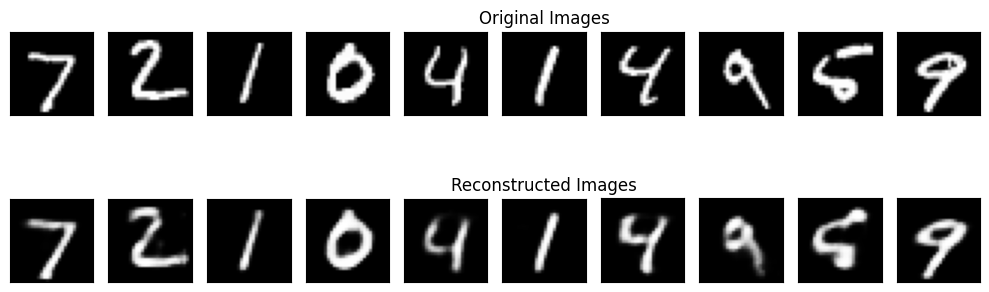

In [10]:
# --- Visualization (Optional: Show original vs reconstructed) ---
n_display = 10
plt.figure(figsize=(10, 4))
for i in range(n_display):
    # display original
    ax = plt.subplot(2, n_display, i + 1)
    plt.imshow(test_images[i].cpu().squeeze(), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n_display // 2:
        ax.set_title("Original Images")

    # display reconstruction
    ax = plt.subplot(2, n_display, i + 1 + n_display)
    plt.imshow(decoded_images[i].cpu().view(28, 28), cmap='gray') # Reshape back to 28x28
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n_display // 2:
        ax.set_title("Reconstructed Images")
plt.tight_layout()
plt.show()

## Demonstrating why averaging latent points doesn't work

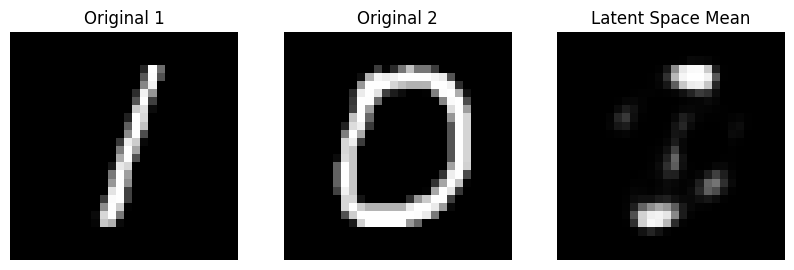

In [11]:
with torch.no_grad():
    encoded = model.encode(test_images_flat)
    decoded = model.decode(encoded)

# --- Demonstrating why averaging latent points doesn't work ---
# Select two random digits from test images
idx1, idx2 = 2, 10  # You can change these
z1 = encoded[idx1]
z2 = encoded[idx2]

# Compute the average in latent space
z_avg = (z1 + z2) / 2

# Decode the average
decoded_avg = model.decode(z_avg.unsqueeze(0))

# --- Visualization ---
plt.figure(figsize=(10, 4))

# Display first original image
ax = plt.subplot(1, 3, 1)
plt.imshow(test_images[idx1].cpu().squeeze(), cmap="gray")
ax.set_title("Original 1")
ax.axis("off")

# Display second original image
ax = plt.subplot(1, 3, 2)
plt.imshow(test_images[idx2].cpu().squeeze(), cmap="gray")
ax.set_title("Original 2")
ax.axis("off")

# Display decoded average
ax = plt.subplot(1, 3, 3)
plt.imshow(decoded_avg.cpu().detach().view(28, 28).numpy(), cmap="gray")
ax.set_title("Latent Space Mean")
ax.axis("off")

plt.show()

# C-Variational Autoencoder

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class CVAE(nn.Module):
    def __init__(self, input_channels=1, num_classes=10, latent_dim=2):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.input_channels = input_channels

        # --- Encoder ---
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(input_channels + num_classes, 32, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 14x14 -> 7x7
            nn.ReLU(),
            nn.Flatten()
        )
        self.encoder_output_dim = 64 * 7 * 7
        self.fc_mu = nn.Linear(self.encoder_output_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.encoder_output_dim, latent_dim)

        # --- Decoder ---
        self.decoder_input = nn.Linear(latent_dim + num_classes, self.encoder_output_dim)
        self.decoder_unflatten = nn.Unflatten(1, (64, 7, 7))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channels, kernel_size=4, stride=2, padding=1),  # 14x14 -> 28x28
            nn.Sigmoid()
        )

    def encode(self, x, label_map):
        # label_map is already shaped [batch, num_classes, 28, 28]
        x_cond = torch.cat([x, label_map], dim=1)
        h = self.encoder_conv(x_cond)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, labels):
        # z shape: [batch, latent_dim], labels shape: [batch, num_classes]
        z_cond = torch.cat([z, labels], dim=1)
        h = self.decoder_input(z_cond)
        h = self.decoder_unflatten(h)
        return self.decoder_conv(h)

    def forward(self, x, label_map):
        # label_map has shape [batch, num_classes, 28, 28]
        labels_flat = label_map[:, :, 0, 0]  # Extract [batch, num_classes] from spatial map
        mu, logvar = self.encode(x, label_map)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, labels_flat)
        return x_recon, mu, logvar


# Hyperparameters
latent_dim = 2  # Dimensionality of the latent space
batch_size = 128
learning_rate = 1e-3
beta = 1.0       # Weight for KL divergence (beta=1 for standard VAE)
num_epochs = 15  # Train for a bit longer

Using device: cpu


In [22]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()  # Converts PIL image to tensor [C, H, W] and scales to [0, 1]
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, optimizer
model = CVAE(latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Loss function (Negative ELBO)
def loss_function(x, x_reconstructed, mu, logvar, beta):
    recon_loss = nn.functional.binary_cross_entropy(x_reconstructed, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = recon_loss + beta * kl_div
    return total_loss, recon_loss, kl_div

# Training loop
print("Training CVAE...")
model.train()
for epoch in range(num_epochs):
    total_loss_epoch = 0
    total_recon_loss_epoch = 0
    total_kl_div_epoch = 0
    for i, (x, labels) in enumerate(train_loader):
        x = x.to(device)

        # Convert labels to one-hot and expand to [B, 10, 28, 28] for channel-wise concat
        labels = torch.nn.functional.one_hot(labels, num_classes=10).float().to(device)
        label_map = labels.view(labels.size(0), 10, 1, 1).expand(-1, 10, 28, 28)

        x_reconstructed, mu, logvar = model(x, label_map)
        loss, recon_loss, kl_div = loss_function(x, x_reconstructed, mu, logvar, beta)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss_epoch += loss.item()
        total_recon_loss_epoch += recon_loss.item()
        total_kl_div_epoch += kl_div.item()

        if (i + 1) % 100 == 0:
            avg_loss = loss.item() / len(x)
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {avg_loss:.4f}')

    avg_epoch_loss = total_loss_epoch / len(train_loader.dataset)
    avg_epoch_recon = total_recon_loss_epoch / len(train_loader.dataset)
    avg_epoch_kl = total_kl_div_epoch / len(train_loader.dataset)
    print(f'====> Epoch: {epoch+1} Average loss: {avg_epoch_loss:.4f} (Recon: {avg_epoch_recon:.4f}, KL: {avg_epoch_kl:.4f})')
cvae_model = model

Training CVAE...
Epoch [1/15], Step [100/469], Loss: 183.1273
Epoch [1/15], Step [200/469], Loss: 155.7395
Epoch [1/15], Step [300/469], Loss: 152.1951
Epoch [1/15], Step [400/469], Loss: 148.8981
====> Epoch: 1 Average loss: 173.7316 (Recon: 167.7200, KL: 6.0115)
Epoch [2/15], Step [100/469], Loss: 144.5456
Epoch [2/15], Step [200/469], Loss: 139.9872
Epoch [2/15], Step [300/469], Loss: 143.8382
Epoch [2/15], Step [400/469], Loss: 133.4549
====> Epoch: 2 Average loss: 141.2185 (Recon: 136.8437, KL: 4.3749)
Epoch [3/15], Step [100/469], Loss: 136.9048
Epoch [3/15], Step [200/469], Loss: 136.7192
Epoch [3/15], Step [300/469], Loss: 139.6743
Epoch [3/15], Step [400/469], Loss: 130.7880
====> Epoch: 3 Average loss: 137.2584 (Recon: 132.8906, KL: 4.3678)
Epoch [4/15], Step [100/469], Loss: 136.6460
Epoch [4/15], Step [200/469], Loss: 130.5132
Epoch [4/15], Step [300/469], Loss: 138.7015
Epoch [4/15], Step [400/469], Loss: 133.7016
====> Epoch: 4 Average loss: 135.4461 (Recon: 131.0753, KL:

Generating digit-conditioned samples from prior...


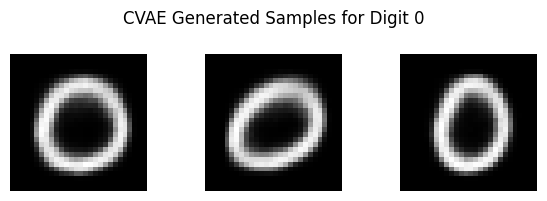

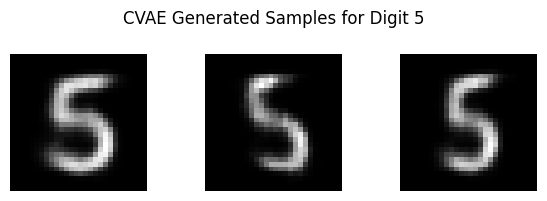

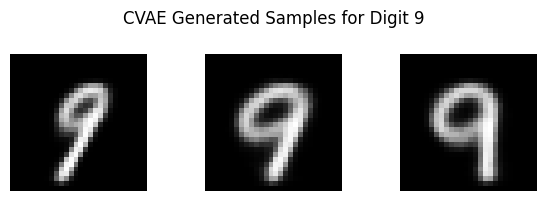

In [17]:
# --- Conditional Generation: Generate digits using specific labels ---
print("Generating digit-conditioned samples from prior...")
model.eval()
digits = [0, 5, 9]
samples_per_digit = 3

with torch.no_grad():
    for digit in digits:
        # Create one-hot encoded label tensor
        labels = torch.tensor([digit] * samples_per_digit).to(device)
        one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=10).float()

        # Sample latent vectors from N(0, I)
        z_sample = torch.randn(samples_per_digit, latent_dim).to(device)

        # Decode conditioned on label
        generated_images = model.decode(z_sample, one_hot_labels).cpu()

        # Plot the generated images
        fig, axes = plt.subplots(1, samples_per_digit, figsize=(samples_per_digit * 2, 2))
        for i in range(samples_per_digit):
            axes[i].imshow(generated_images[i].squeeze(), cmap='gray')
            axes[i].axis('off')
        plt.suptitle(f"CVAE Generated Samples for Digit {digit}")
        plt.tight_layout()
        plt.show()

Plotting 2D latent space for CVAE...


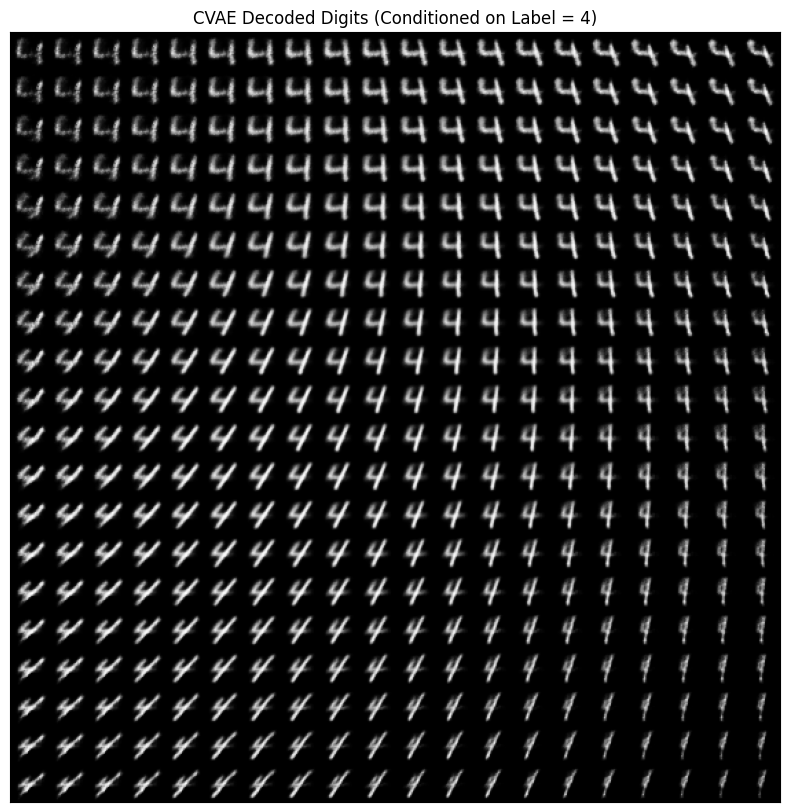

CVAE(
  (encoder_conv): Sequential(
    (0): Conv2d(11, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=3136, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=3136, out_features=2, bias=True)
  (decoder_input): Linear(in_features=12, out_features=3136, bias=True)
  (decoder_unflatten): Unflatten(dim=1, unflattened_size=(64, 7, 7))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)

In [18]:
# --- Latent Space Grid Visualization (CVAE) ---
print("Plotting 2D latent space for CVAE...")
model.eval()
model.to("cpu")  # Ensure it's on CPU for plotting

def plot_cvae_latent_grid(model, n=20, digit_size=28, xlim=(-3, 3), ylim=(-3, 3)):
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(xlim[0], xlim[1], n)
    grid_y = np.linspace(ylim[0], ylim[1], n)[::-1]

    with torch.no_grad():
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = torch.tensor([[xi, yi]]).float()
                # Choose a digit to condition on — e.g., always '4'
                label = 4
                one_hot = torch.nn.functional.one_hot(torch.tensor([label]), num_classes=10).float()
                x_decoded = model.decode(z_sample, one_hot)
                digit_img = x_decoded[0].reshape(digit_size, digit_size).numpy()
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit_img

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.title("CVAE Decoded Digits (Conditioned on Label = 4)")
    plt.show()

plot_cvae_latent_grid(model)
model.to(device)
